In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jun 23 12:13:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory

ram = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM.'.format(ram))
if ram < 20:
    print('To enable a high-RAM runtime, select the Runtime > "Change runtime type", then select High-RAM in the Runtime shape dropdown '
          'and then re-execute this cell.')
else:
    print('You are using a high-RAM runtime.')

Your runtime has 13.6 gigabytes of available RAM.
To enable a high-RAM runtime, select the Runtime > "Change runtime type", then select High-RAM in the Runtime shape dropdown and then re-execute this cell.


In [ ]:
from tensorflow import config

physical_devices = config.list_physical_devices('GPU')
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except Exception as exception:
    print(exception)

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 8.0MB/s 


In [ ]:
from keras.utils.vis_utils import plot_model
from tensorflow import device
from tensorflow import image
from tensorflow_addons import layers as new_layers
from tensorflow.keras import activations
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import optimizers

import csv
import gc
import h5py
import numpy as np
import os

In [ ]:
town = 'Moscow'  #@param ['Berlin', 'Istanbul', 'Moscow']

dynamic_files = '/content/gdrive/My Drive/Licenta/Traffic4Cast/{}/files/training'.format(town)
static_file_path = '/content/gdrive/My Drive/Licenta/Traffic4Cast/{}/files/{}_static_2019.h5'.format(town, town.upper())

checkpoints = '/content/gdrive/My Drive/Licenta/Traffic4Cast/{}/checkpoints/UNet12'.format(town)
logs = '/content/gdrive/My Drive/Licenta/Traffic4Cast/{}/logs/UNet12/training/logs.csv'.format(town)

In [ ]:
def get_file_names(files):
    file_names = os.listdir(files)[90:]
    np.random.shuffle(file_names)
    return file_names

In [ ]:
def get_dynamic_data(file_path, index):
    file = h5py.File(file_path, 'r')
    group_key = list(file.keys())[0]
    data = np.array(file[group_key][index:index + 72], dtype=np.float32)  # (72, 495, 436, 9)
    file.close()
    return data

In [ ]:
def get_static_data(file_path):
    file = h5py.File(file_path, 'r')
    group_key = list(file.keys())[0]
    data = np.array(file[group_key][:], dtype=np.float32)  # (495, 436, 7)
    file.close()
    return data

In [ ]:
def get_data(file_path, index, static_data):
    data = get_dynamic_data(file_path, index)
    data = np.array(np.split(data, 3))  # split in 3 batches of 12 + 12 timestamps
    np.random.shuffle(data)  # shuffle the batches
    inputs = data[:, :12, :, :, :]
    outputs = data[:, 12:, :, :, :]
    outputs = np.take(outputs, np.arange(8), axis=-1)  # keep only the dynamic channels
    inputs = np.moveaxis(inputs, 1, -1).reshape((3, 495, 436, -1))  # combine the timestamps with the channels
    outputs = np.moveaxis(outputs, 1, -1).reshape((3, 495, 436, -1))  # combine the timestamps with the channels
    static_data = np.repeat(np.expand_dims(static_data, axis=0), repeats=3, axis=0)  # (3, 495, 436, 7)
    inputs = np.concatenate((inputs, static_data), axis=-1)  # add static data
    return inputs / 255.0, outputs / 255.0

In [ ]:
def get_convolution_block(inputs, filters):
    outputs = layers.Conv2D(filters=filters, kernel_size=3, padding='same')(inputs)
    outputs = new_layers.GroupNormalization()(outputs)
    outputs = layers.Activation(activations.relu)(outputs)

    outputs = layers.Conv2D(filters=filters, kernel_size=3, padding='same')(outputs)
    outputs = new_layers.GroupNormalization()(outputs)
    outputs = layers.Activation(activations.relu)(outputs)

    return outputs

In [ ]:
def get_encoder_block(inputs, filters):
    outputs = get_convolution_block(inputs, filters)  # skip features
    pool = layers.MaxPool2D(pool_size=2, strides=2, padding='same')(outputs)
    return outputs, pool

In [ ]:
def get_decoder_block(inputs, skip_features, filters):
    outputs = layers.Conv2DTranspose(filters=filters, kernel_size=2, strides=2, padding='same')(inputs)
    outputs = image.resize(outputs, skip_features.get_shape()[1:3])
    outputs = layers.Concatenate()([outputs, skip_features])
    outputs = get_convolution_block(outputs, filters)
    return outputs

In [ ]:
def get_model():
    inputs = layers.Input(shape=(495, 436, 115), name='inputs')

    encoder_block_1, pool_1 = get_encoder_block(inputs, filters=64)
    encoder_block_2, pool_2 = get_encoder_block(pool_1, filters=128)
    encoder_block_3, pool_3 = get_encoder_block(pool_2, filters=256)
    encoder_block_4, pool_4 = get_encoder_block(pool_3, filters=512)

    convolution_block = get_convolution_block(pool_4, 1024)

    decoder_block_1 = get_decoder_block(convolution_block, encoder_block_4, 512)
    decoder_block_2 = get_decoder_block(decoder_block_1, encoder_block_3, 256)
    decoder_block_3 = get_decoder_block(decoder_block_2, encoder_block_2, 128)
    decoder_block_4 = get_decoder_block(decoder_block_3, encoder_block_1, 64)

    outputs = layers.Conv2D(filters=96, kernel_size=1, padding='same')(decoder_block_4)

    return models.Model(inputs=inputs, outputs=outputs)

In [ ]:
with device('gpu:0'):
    model = get_model()
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss=losses.mean_squared_error)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 495, 436, 11 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 495, 436, 64) 66304       inputs[0][0]                     
__________________________________________________________________________________________________
group_normalization (GroupNorma (None, 495, 436, 64) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 495, 436, 64) 0           group_normalization[0][0]        
______________________________________________________________________________________________

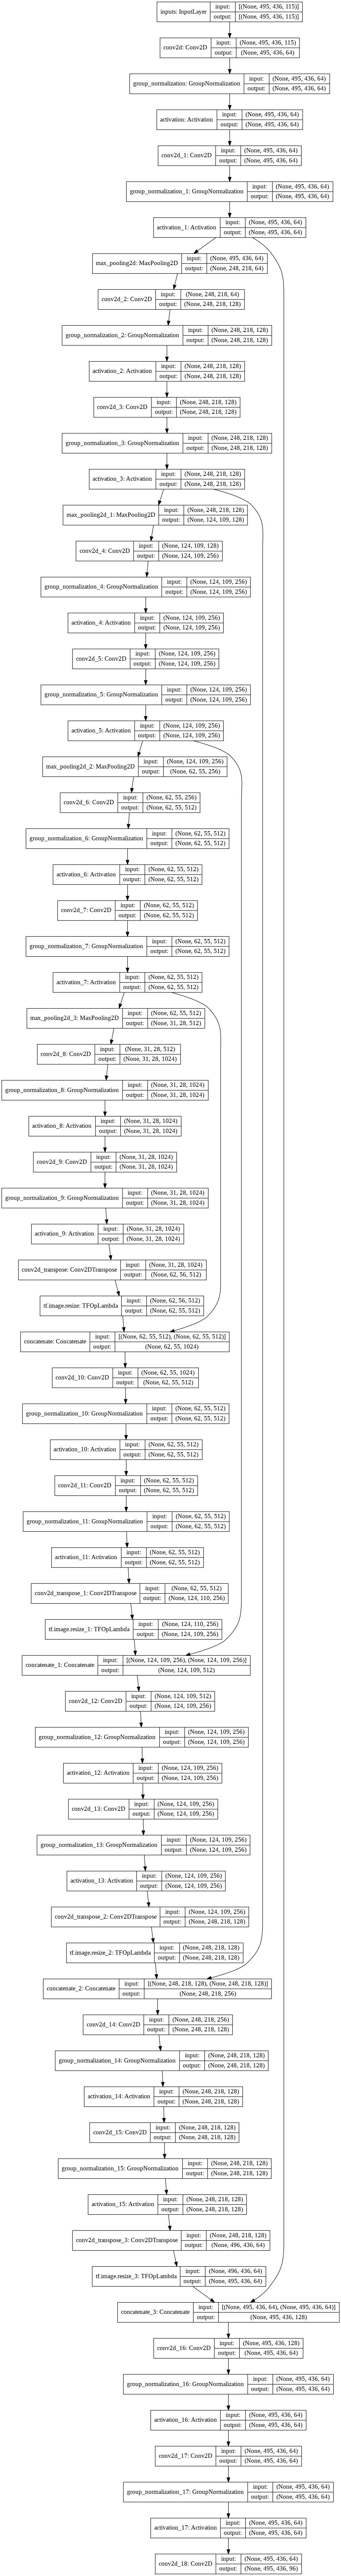

In [ ]:
plot_model(model, to_file='u_net_12.png', show_shapes=True, show_layer_names=True)

In [ ]:
static_data = get_static_data(static_file_path)

log_file = open(logs, 'w', newline='')
log_writer = csv.writer(log_file)
log_writer.writerow(['epoch', 'file', 'loss'])
log_file.flush()

In [ ]:
for epoch in range(20):
    print('epoch:', epoch)
    file_names = get_file_names(dynamic_files)
    for index, file_name in enumerate(file_names):
        print('file:', index)
        losses = np.zeros(shape=(4,), dtype=np.float64)
        for index in range(0, 288, 72):
            inputs, outputs = get_data(os.path.join(dynamic_files, file_name), index, static_data)
            with device('gpu:0'):
                history = model.fit(inputs, outputs, epochs=1, batch_size=3)
                losses[index // 72] = history.history['loss'][0]
        log_writer.writerow([epoch, file_name, np.mean(losses, dtype=np.float64)])
        log_file.flush()
        gc.collect()
    model.save(os.path.join(checkpoints, 'model_{}.h5'.format(epoch)))

In [ ]:
log_file.close()